In [44]:
import torch
import torch.nn as nn
from torchdiffeq import odeint
import sys; sys.path.append(2*'../')
from src import *
import matplotlib.pyplot as plt

# device = torch.device('cuda:1') # for second gpu
device = 'cpu' # feel free to change :)


plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

In [45]:
m, k = 1, 0.5

class ControlledSystem(nn.Module):
    """Spring-mass system"""
    def __init__(self, u):
        super().__init__()
        self.u = u
        
    def forward(self, t, x):
        q, p = x[...,:1], x[...,1:]
        dq = p/m
        dp = -k*q + self.u
        return torch.cat([dq, dp], -1)
    
def R(X, u, Δt, method, hypereuler=None, base_solver='dopri5'):
    t_span = torch.tensor([0, Δt]).to(device)
    with torch.no_grad():
        if base_solver == 'analytical':
             x_fine = forward_linear_system(X, u, Δt)
        else:
             x_fine = odeint(ControlledSystem(u), X, t_span, method='dopri5')[-1]
        if hypereuler:
            xfu = torch.cat([X, ControlledSystem(u)(0, X), u], -1)
            x_coarse =  X + Δt*ControlledSystem(u)(0, X) + (Δt**2)*hypereuler(xfu)
        else:
            x_coarse = odeint(ControlledSystem(u), X, t_span, method=method)[-1]
        R = (x_fine - x_coarse)/(Δt**2)
        L = torch.norm(R, dim=-1, p=2)
        return L

## [Supplementary] Calculating the analytical residuals for linear systems

$\dot x_t = A x_t + B u_t ~\Rightarrow x_{k+1} = e^{A\Delta t}x_k + (e^{A\Delta t} - I)A^{-1}B u_k~$

$x_{k+1} = x_k + \Delta t (Ax_k + Bu_k)$

$R_{x_k}(u_k) = e^{A\Delta t}x_k + (e^{A\Delta t} - I)A^{-1}B u_k - x_k - \Delta t (Ax_k + Bu_k)$

In [46]:
device = 'cpu'

In [47]:
# System dynamics
A = torch.tensor([[0, 1/m],
                  [-k,  0]]).to(device)
B = torch.tensor([[0],
                  [1.]]).to(device)

def forward_linear_system(x, u, Δt):
    '''Solve linear system analytically for one step
    Works with batched input
    '''
    eAΔt = torch.matrix_exp(A*Δt)
    I = torch.eye(A.shape[0]).to(device)
    Ainv = torch.inverse(A)
    # Non pensar male...
    x_anal = torch.einsum('kl, bjl-> bjk', eAΔt, x) \
           + torch.einsum('kl, bjl -> bjk', torch.mm(torch.mm((eAΔt - I), Ainv), B), u)
    return x_anal

## Training with single $\Delta t$

In [48]:
Δt = .03

x_min_train, x_max_train = -20, 20
u_lim = 100
bs_hs = 1000
n_grid = 100

In [49]:
def residual_loss(g, X, u, Δt, method, base_solver='dopri5', order=1):
    t_span = torch.tensor([0, Δt]).to(device)
    if base_solver == 'analytical':
        x_fine = forward_linear_system(X, u, Δt)
    else:
        x_fine = odeint(ControlledSystem(u), X, t_span, method='dopri5')[-1]
    x_coarse = odeint(ControlledSystem(u), X, t_span, method=method)[-1]
    xfu = torch.cat([X, ControlledSystem(u)(0, X), u], -1)
    return torch.norm(x_fine - x_coarse - (Δt**(order+1))*g(xfu), p=2, dim=-1)/(Δt**(order+1))

## Training with Stochastic Exploration

In [50]:
hdim = 32
hs_stochastic = nn.Sequential(
    nn.Linear(5, hdim),
    nn.Softplus(),
    nn.Linear(hdim, hdim),
    nn.Tanh(),
    nn.Linear(hdim, 2)).to(device)

from tqdm import trange

EPOCHS = 10000
losses = []
opt_hs = torch.optim.Adam(hs_stochastic.parameters(), lr=1e-3)
with trange(0, EPOCHS, desc="Epochs") as epochs:
    for epoch in epochs:
        '''Hypersolver training loop with given Δt_test'''
        opt_hs.zero_grad()
        # Randomize state and controller values
        x = torch.Tensor(bs_hs, 2).uniform_(x_min_train, x_max_train).to(device)
        #_grid = x.repeat(n_grid, 1, 1).detach()
        u_rand = torch.Tensor(bs_hs, 1).uniform_(-u_lim, u_lim).to(device)
        loss = residual_loss(hs_stochastic, x[:, None, :], u_rand[:, None, :],  Δt, 'euler').mean()
        # Optimization step
        loss.backward()
        opt_hs.step()
        losses.append(loss.detach().cpu())
        # print(f"e:{epoch}, loss:%.3f" % loss, end="\r")
        epochs.set_postfix(loss=(loss.detach().cpu().item()))

Epochs: 100%|██████████| 10000/10000 [00:56<00:00, 176.29it/s, loss=0.227]


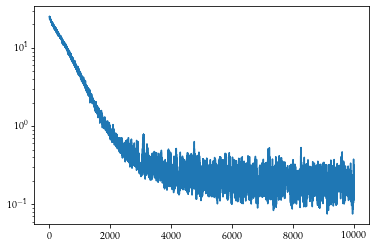

In [51]:
fig, ax = plt.subplots(1,1)
ax.plot(losses); ax.set_yscale('log')


## Training with Active Error Minimization

In [52]:
hdim = 32
hs_active = nn.Sequential(
    nn.Linear(5, hdim),
    nn.Softplus(),
    nn.Linear(hdim, hdim),
    nn.Tanh(),
    nn.Linear(hdim, 2)).to(device)
losses = []

opt_hs = torch.optim.Adam(hs_active.parameters(), lr=1e-3)
with trange(0, EPOCHS, desc="Epochs") as epochs:
    for epoch in epochs:
        '''Hypersolver training loop with given Δt_test'''
        opt_hs.zero_grad()
        
        # Randomize state and controller values
        x = torch.Tensor(bs_hs, 2).uniform_(x_min_train, x_max_train).to(device)

        # Find the argmax
        x_grid = x.repeat(n_grid, 1, 1).detach()
        controller_grid = torch.Tensor(n_grid, 1, 1).uniform_(-u_lim, u_lim).to(device)
        controller_grid = controller_grid.repeat(1, bs_hs, 1)
        r = residual_loss(hs_active, x_grid, controller_grid,  Δt, method='euler')
        max_r = torch.max(r, 0)
        u_argmax = controller_grid[:,0,:][max_r.indices].to(device)
        # Loss is based on the argmax of controllers we have found
        loss = residual_loss(hs_active, x[:, None, :], u_argmax[:, None, :],  Δt, 'euler').mean()

        # Optimization step
        loss.backward()
        opt_hs.step()
        losses.append(loss.detach().cpu())
        # print(f"e:{epoch}, loss:%.3f" % loss, end="\r")
        epochs.set_postfix(loss=(loss.detach().cpu().item()))

Epochs: 100%|██████████| 10000/10000 [10:31<00:00, 15.85it/s, loss=0.586]


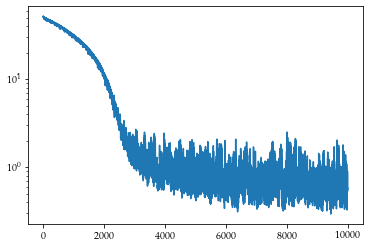

In [53]:
fig, ax = plt.subplots(1,1)
ax.plot(losses); ax.set_yscale('log')

In [54]:
torch.save(hs_stochastic, 'saved_models/hs_stochastic.pt')
torch.save(hs_active, 'saved_models/hs_active.pt')

## Plotting

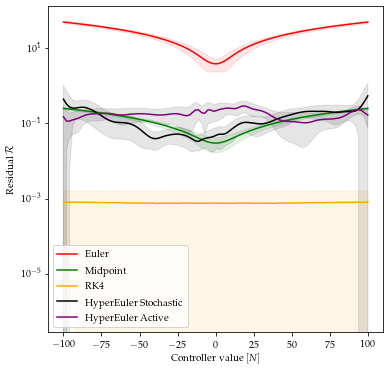

In [55]:
import matplotlib.pyplot as plt

n_x, n_u = 10000, 100
x = torch.Tensor(n_x, 2).uniform_(x_min_train, x_max_train).to(device)
qp = torch.linspace(x_min_train, x_max_train, 100) ; Q, P = torch.meshgrid(qp, qp) ; x = torch.cat([Q.reshape(-1, 1), P.reshape(-1, 1)], -1).to(device)
u = torch.linspace(-u_lim, u_lim, n_u)[:,None].to(device)

X = x.repeat(n_u, 1, 1)
U = u.repeat(n_x, 1, 1).permute(1, 0, 2)
X = X.cpu()
U = U.cpu()

res_euler = R(X, U, Δt, 'euler').cpu()
res_hypereuler_stochastic = R(X, U, Δt, 'euler', hypereuler=hs_stochastic.cpu()).cpu()
res_hypereuler_active = R(X, U, Δt, 'euler', hypereuler=hs_active.cpu()).cpu()
# res_hypereuler_max = R(X, U, Δt, 'euler', hypereuler=hs_max.cpu()).cpu()
res_midpoint = R(X, U, Δt, 'midpoint').cpu()
res_rk = R(X, U, Δt, 'rk4').cpu()
# res_dopri = R(X, U, Δt, 'dopri5').cpu()

u = u.cpu().squeeze()

alpha = .1

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(u, res_euler.mean(1), label='Euler', color='r')
ax.fill_between(u, res_euler.mean(1) - res_euler.std(1),
                res_euler.mean(1) + res_euler.std(1), alpha=alpha, color='red')
ax.plot(u, res_midpoint.mean(1), label='Midpoint', color='g')
ax.fill_between(u, res_midpoint.mean(1) - res_midpoint.std(1),
                res_midpoint.mean(1) + res_midpoint.std(1), alpha=alpha, color='green')
ax.plot(u, res_rk.mean(1), label='RK4', color='orange')
ax.fill_between(u, res_rk.mean(1) - res_rk.std(1),
                res_rk.mean(1) + res_rk.std(1), alpha=alpha, color='orange')
# ax.plot(u, res_dopri.mean(1), label='Dopri5', color='purple')
# ax.fill_between(u, res_dopri.mean(1) - res_dopri.std(1),
#                 res_dopri.mean(1) + res_dopri.std(1), alpha=alpha, color='purple')

# HyperEuler
ax.plot(u, res_hypereuler_stochastic.mean(1), label='HyperEuler Stochastic', color='k')
ax.fill_between(u, res_hypereuler_stochastic.mean(1) - res_hypereuler_stochastic.std(1),
                res_hypereuler_stochastic.mean(1) + res_hypereuler_stochastic.std(1), alpha=alpha, color='black')
ax.plot(u, res_hypereuler_active.mean(1), label='HyperEuler Active', color='purple')
ax.fill_between(u, res_hypereuler_active.mean(1) - res_hypereuler_active.std(1),
                res_hypereuler_active.mean(1) + res_hypereuler_active.std(1), alpha=alpha, color='black')


ax.set_xlabel(r'Controller value $[N]$')
ax.set_ylabel(r'Residual $\mathcal{R}$')
ax.legend()
ax.set_yscale('log')

# plt.savefig('images/residuals_linear.pdf')

# import tikzplotlib
# tikzplotlib.save("images/residuals_linear.tex")

In [56]:
def mae(yhat, y):
    '''Calculate MAE: Mean Average Error
    '''
    with torch.no_grad():
        err = torch.abs(yhat - y).mean(dim=2)
    return err.mean(1).numpy(), err.std(1).numpy()

def mape(yhat, y):
    '''Calculate MAPE: Mean Average Percentage Error
    '''    
    with torch.no_grad():
        err = torch.abs((yhat - y)/yhat).mean(dim=2)
    return err.mean(1).numpy(), err.std(1).numpy() 

## Propagate the system forward

In [72]:
tf = 0.3
t_span = torch.linspace(0, tf, int(tf/Δt) + 1)
bs = 10000
x0 = torch.Tensor(bs, 2).uniform_(x_min_train/5, x_max_train/5)

# We propagate the system forward one step at a time
def random_forward_propagation(x0, t_span, hypersolver=None, bang_bang=False, method='midpoint'):
    sys = ControlledSystem(1)
    x, x_nom = [x0[None]], [x0[None]]
    xt, xt_nom = x0[None], x0[None]
    bs = x0.shape[0]
    for t in range(len(t_span)-1):
        if bang_bang: u = 2*u_lim*torch.randint(2, (1, bs, 1), dtype=torch.float) - u_lim
        # if bang_bang: u = torch.Tensor([100], dtype=torch.float).repead()
        else: u = torch.Tensor(1, bs, 1).uniform_(-u_lim, u_lim)
        sys.u = (u.float())
        diff_span = torch.linspace(t, t+Δt, 2)
        if hypersolver:
            f = sys(t, xt)
            xfu = torch.cat([xt, f, u], -1)
            # Hypersolver
            xt = xt + Δt*f + Δt**2*hypersolver(xfu)
        else:
            xt = odeint(sys, xt, diff_span, method=method)[-1]
        # Nominal
        xt_nom = odeint(sys, xt_nom, diff_span, method='dopri5')[-1]
        # You can also change to the analytical version
        # xt_nom = forward_linear_system(xt_nom, u, Δt) 
        x.append(xt); x_nom.append(xt_nom)
    return torch.cat(x), torch.cat(x_nom)

he_traj, nom_traj = random_forward_propagation(x0, t_span, hs_stochastic)
he_traj_argmax, nom_traj_argmax = random_forward_propagation(x0, t_span, hs_active)
mp_traj, nom_traj_mp = random_forward_propagation(x0, t_span, method='midpoint')
he_traj_bb, nom_traj_bb = random_forward_propagation(x0, t_span, hs_stochastic, bang_bang=True)
he_traj_argmax_bb, nom_traj_argmax_bb = random_forward_propagation(x0, t_span, hs_active, bang_bang=True)
mp_traj_bb, nom_traj_mp_bb = random_forward_propagation(x0, t_span, method='midpoint', bang_bang=True)

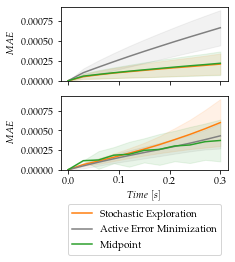

In [73]:
# Plotting
# stochastic, active hypersolvers and midpoint
# random
err_he, std_he = mae(nom_traj, he_traj)
err_he_argmax, std_he_argmax = mae(nom_traj_argmax, he_traj_argmax)
err_mp, std_mp = mae(mp_traj, nom_traj_mp)

# bang-bang
err_he_bb, std_he_bb = mae(nom_traj_bb, he_traj_bb)
err_he_argmax_bb, std_he_argmax_bb = mae(nom_traj_argmax_bb, he_traj_argmax_bb)
err_mp_bb, std_mp_bb = mae(mp_traj_bb, nom_traj_mp_bb)


fig, ax = plt.subplots(2, 1, figsize=(3, 3))
alpha = .1

ax[0].plot(t_span, err_he, label='Stochastic exploration', color='tab:orange')
ax[0].fill_between(t_span, err_he - std_he, err_he + std_he, alpha=alpha, color='tab:orange')
ax[0].plot(t_span, err_he_argmax, label='Active residual minimization', color='grey')
ax[0].fill_between(t_span, err_he_argmax - std_he_argmax, err_he_argmax + std_he_argmax, alpha=alpha,color='grey')
ax[0].plot(t_span, err_mp, label='Midpoint', color='tab:green')
ax[0].fill_between(t_span, err_mp - std_mp, err_mp + std_mp, alpha=alpha,color='tab:green')

# ax[0].set_title(r'$Random~control~input$')
ax[0].set_xlabel(r'$Time~[s]$')
ax[0].set_ylabel(r'$MAE$')

ax[1].plot(t_span, err_he_bb, label='Stochastic Exploration', color='tab:orange')
ax[1].fill_between(t_span, err_he_bb - std_he_bb, err_he_bb + std_he_bb, alpha=alpha, color='tab:orange')
ax[1].plot(t_span, err_he_argmax_bb, label='Active Error Minimization',color='grey')
ax[1].fill_between(t_span, err_he_argmax_bb - std_he_argmax_bb, err_he_argmax_bb + std_he_argmax_bb, alpha=alpha, color='grey')
ax[1].plot(t_span, err_mp_bb, label='Midpoint', color='tab:green')
ax[1].fill_between(t_span, err_mp_bb - std_mp_bb, err_mp_bb + std_mp_bb, alpha=alpha,color='tab:green')
ax[1].legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.4))
# ax[1].set_title(r'$Bang-bang~controller$')
ax[1].set_xlabel(r'$Time~[s]$')
ax[1].set_ylabel(r'$MAE$')
# ax[0].set_yscale('log')
# ax[1].set_yscale('log')

for ax in ax:
    ax.label_outer()
    ax.yaxis.set_major_locator(plt.MaxNLocator(4))    
    # ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax.set_ylim(bottom=0)
# plt.suptitle('Error propagation with different hypersolver pre-training',fontsize=14, weight='semibold', y=.97)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.4),
          fancybox=True, shadow=False, ncol=1)

plt.savefig('media/residuals_stochastic_active.pdf', bbox_inches='tight')
import tikzplotlib
tikzplotlib.save("media/residuals_stochastic_active.tex")